# Impact of the Number of Airbnb on London House Prices
## CASA0013:European R&D Centre
### Students Ids:22124399,22124400,22097721,22098674

# 1. Preamble

## 1.1 Loading the Main Libraries

In [1]:
#This block will load the packages that must be used for this analysis. 
#If you get an error, the package may not be installed in your environment, 
#so please run: "pip install 'package name' at the start of this block".
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels
import os
import geopandas as gpd
import matplotlib.cm as cm
import umap
import matplotlib
from scipy import stats
from kneed import knee_locator
from requests import get
from urllib.parse import urlparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

## 1.2 Define the Download Function

In [2]:
#Define the function for downloading files to facilitate subsequent downloads
#'src' is the source address of the downloaded file
# 'dest' is the destination address of the downloaded file
def cache_data(src:str, dest:str) -> str:
    # read the path of URL
    url = urlparse(src)
    # read the document
    fn  = os.path.split(url.path)[-1] 
    # dwonload the document
    dfn = os.path.join(dest,fn) 
    #Respond to different prompts depending on the situation
    if not os.path.isfile(dfn):       
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)     
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)         
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)         
        print('Done downloading...')
    else:
        #If the document already exists, reply that it was found
        print(f"Found {dfn} locally!")
    return dfn

# 2. Data Loading and Data Cleaning

## 2.1 Data Loading

### 2.1.1 Download London Boundary Vector Data

In [3]:
#Create a data path in the root directory, ignore this if it exists
from pathlib import Path
folder_path = Path('./data')
folder_path.mkdir(exist_ok=True)

In [4]:
#Download the wards data
#Determine where to add the file
ddir  = os.path.join('data') 
#Determine the source directory of the downloaded file
spath = 'https://github.com/TiannanGe/CASA/blob/main/CASA13Foundation/'
wards = gpd.read_file( cache_data(spath+'London_Ward.gpkg?raw=true', ddir) )
print('Done.')

Found data/London_Ward.gpkg locally!
Done.


In [5]:
#Download the boroughes data
#Determine the source
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' 
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
print('Done.')

Found data/Boroughs.gpkg locally!
Done.


### 2.1.2 Download Statistics

In [6]:
#Download the ward-profiles data
spath = 'https://raw.githubusercontent.com/TiannanGe/CASA/main/CASA13Foundation/'
wp = pd.read_csv( cache_data(spath+'ward-profiles-excel-version.csv', ddir) )
print('Done.')

Found data/ward-profiles-excel-version.csv locally!
Done.


### 2.1.3 Download the Airbnb Data

In [7]:
#Download the Airbnb dataset
#remove the useless attribute columns after 13MB and assign the value to df
ddir  = os.path.join('data') 
#Determine the source
spath = 'https://github.com/TiannanGe/CASA/blob/main/CASA13Foundation/' 
fn = 'listings.csv'
df = pd.read_csv( cache_data(spath + fn + '?raw=true', ddir),encoding='latin-1')
print('Done.')

Found data/listings.csv locally!
Done.


/tmp/ipykernel_17859/1091912096.py:7: DtypeWarning: Columns (24,25,28,29,31,32,33,34,35,36,37,38,39,40,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv( cache_data(spath + fn + '?raw=true', ddir),encoding='latin-1')


## 2.2 Data Cleaning

### 2.2.1 Airbnb Data Cleaning

In [8]:
#Conversion of latitude and longitude data to floating point data
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

#Delete empty columns from a data set
df.drop(df.columns[df.columns.get_loc('calculated_host_listings_count'):], axis=1, inplace=True)

#Delete the null value of latitude and longitude data
df.drop(df[df.latitude.isna()].index.array, axis=0, inplace=True)
df.drop(df[df.longitude.isna()].index.array, axis=0, inplace=True)

#Delete the character data of latitude and longitude and keep the numeric data
df = df[df["latitude"].apply(lambda x: isinstance(x, (int, float)))]
df = df[df["longitude"].apply(lambda x: isinstance(x, (int, float)))]

#View the amount of data remaining after cleaning
print(f"After delete Data frame is {df.shape[0]:,} x {df.shape[1]}")

After delete Data frame is 68,541 x 27


In [9]:
#Clean up Airbnb rental price data, replace symbols and convert to numeric values
df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')
df["price"] = pd.to_numeric(df["price"], errors="coerce")

/tmp/ipykernel_17859/3531600942.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')


In [10]:
#Excluding extreme data: excluding Airbnb rent prices above 10,000
df = df[df['price'] <= 10000]

### 2.2.2 Deletion of Airbnb Points Located Outside of London

In [11]:
df = df[(df["longitude"] >= -0.5236) & (df["longitude"] <= 0.30515)]
df = df[(df["latitude"] >= 51.27248) & (df["latitude"] <= 51.70893)]

In [12]:
#Check Airbnb boundary range
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893


# 3. Data Modification and Join

## 3.1 Defining the Projection of Geographic Data

In [13]:
#Airbnb data converted to geo data frame and defined as 4326, assigned to gdf
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [14]:
#Airbnb's geo data defined as UK-based coordinates
gdf = gdf.to_crs('epsg:27700')
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[502615.87511762 154633.50599878 560027.49389306 202832.88761803]


## 3.2 Data Merge：Import Statistics into Wards

### 3.2.1 Check Ward-profiles (wp) Statistics

In [15]:
wp

,Ward_name,Old_code,New_code,Population2015,All_Children_aged_0_15_2015,All_Working_age_16-64_2015,Mean_Age_2013,Area_Square_Kilometres,Population_density_2013,BAME_2011,...,Claimant_Rate_of_Housing_Benefit_2015,Claimant_Rate_of_Employment_Support_Allowance_2014,Rate_of_JobSeekers_Allowance_JSA_Claimants_2015,Average_GCSE_capped_point_scores_2014,with_Level_4_qualifications_and_above_2011,Crime_rate_2014_15,Violence_against_the_person_rate_2014_15,Deliberate_Fires_per_1000_population_2014,area_that_is_open_space_2014,Average_Public_Transport_Accessibility_score_2014
0,City of London,00AA,E05000001,324,8.0,76.9,41.3,0.128,2538.1,21.4,...,5.3,1.9,1.3,354.5,68.4,656.4,85.3,0.4,18.6,7.9
1,City of London,00AA,E05000002,324,8.0,76.9,41.3,0.128,2538.1,21.4,...,5.3,1.9,1.3,354.5,68.4,656.4,85.3,0.4,18.6,7.9
2,City of London,00AA,E05000003,324,8.0,76.9,41.3,0.128,2538.1,21.4,...,5.3,1.9,1.3,354.5,68.4,656.4,85.3,0.4,18.6,7.9
3,City of London,00AA,E05000004,324,8.0,76.9,41.3,0.128,2538.1,21.4,...,5.3,1.9,1.3,354.5,68.4,656.4,85.3,0.4,18.6,7.9
4,City of London,00AA,E05000005,324,8.0,76.9,41.3,0.128,2538.1,21.4,...,5.3,1.9,1.3,354.5,68.4,656.4,85.3,0.4,18.6,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Waltham Forest,00BH,E09000031,271450,22.0,67.8,34.5,38.800,6897.0,47.8,...,12.2,4.4,3.4,316.7,30.0,83.1,24.3,0.5,34.8,3.6
680,Wandsworth,00BJ,E09000032,322750,17.6,73.5,34.4,35.200,8853.9,28.6,...,10.1,3.4,1.8,326.1,53.6,71.6,19.2,0.3,31.6,4.3
681,Westminster,00BK,E09000033,230550,14.7,73.9,36.7,22.000,10285.8,38.3,...,12.4,5.0,2.2,330.1,50.3,238.3,39.5,0.2,28.6,6.5
682,London,H,E12000007,8632850,20.0,68.6,35.6,1594.700,5292.6,40.2,...,12.2,2.2,2.6,323.7,37.7,83.3,23.4,0.5,39.1,3.8


### 3.2.2 Merge 'wp' Data to Wards

In [16]:
#First projection of wards to 27700 and check Airbnb geo data (gdf), projection of London boundary data (wards and boros) separately, determined to be 27700
wards = wards.to_crs('epsg:27700')
print(gdf.geometry.crs)
print(wards.geometry.crs)
print(boros.geometry.crs)

epsg:27700
epsg:27700
epsg:27700


In [17]:
#Merge wp statistics with wards based on code and assign the merged data to wpwa
wpwa = pd.merge(wp, wards, left_on='New_code', right_on='GSS_CODE')

In [18]:
#Converting wpwa to geodataframe format
wpwa_gdf = gpd.GeoDataFrame(wpwa, geometry='geometry')

In [19]:
#Check data format
type(wpwa_gdf)

geopandas.geodataframe.GeoDataFrame

## 3.3 Data Data Joins：Import Airbnb Data into Wards

### 3.3.1 Join Airbnb Rent Data into Wards

In [20]:
#Check and ensure that the projection of gdf and wpwa_gdf is 27700, if not, you need to run gdf.to_crs()
print(gdf.geometry.crs)
print(wpwa_gdf.geometry.crs)

epsg:27700
epsg:27700


In [21]:
# Use the sjoin() function to make a spatial join
merged_gdf = gpd.sjoin(gdf, wpwa_gdf, how="inner", op='within')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [22]:
#Calculate the average rental price of wards' Airbnb and add it to the table
pricemean = merged_gdf.groupby('GSS_CODE')['price'].mean()
allgdf = pd.merge(wpwa_gdf,pricemean, on='GSS_CODE')

### 3.3.2 Join Airbnb's Number data into Wards

In [23]:
# Calculate the number of Airbnb distributions in each wards
result_gdf = gpd.sjoin(gdf, allgdf, op='within', how='left')
result_gdf = result_gdf.groupby('GSS_CODE').size().reset_index(name='airbnbcnt')
allgdf = allgdf.merge(result_gdf, on='GSS_CODE', how='left')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


# 4. Spatial Presentation of Airbnb Data

## 4.1 Distribution of Airbnb's Numbers（Wards）

Text(0.5, 1.0, "Number of airbnb's group by wards ")

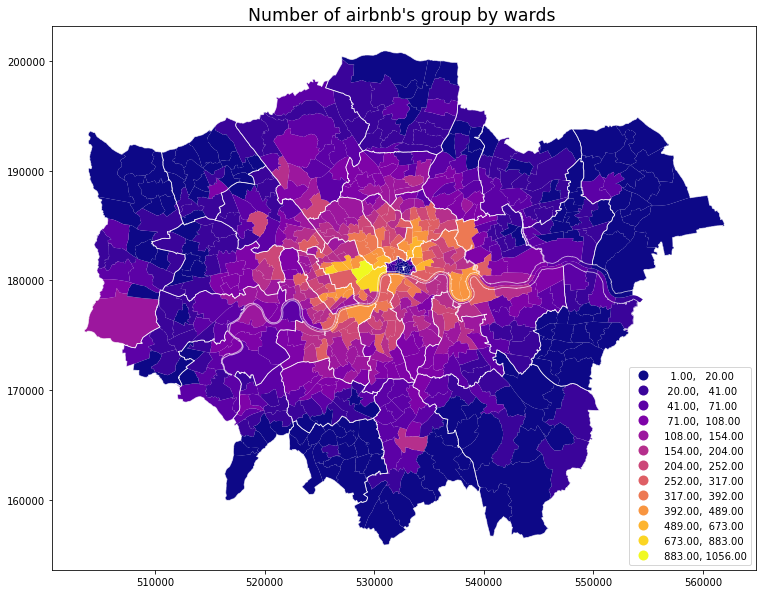

In [24]:
#Spatial representation using the plot function
#To maximise differentiation between wards, k is set to 13 and the classification method used is 'FisherJenks'
ax = allgdf.plot(column='airbnbcnt', cmap='plasma', 
scheme='FisherJenks', k=13, edgecolor='None', legend=True, figsize=(15,10),legend_kwds={'loc':'lower right'});
boros.plot(ax=ax, edgecolor='w', facecolor='none', linewidth=0.8, alpha=0.7)
plt.title("Number of airbnb's group by wards ",fontsize='xx-large')

## 4.2 Distribution of Airbnb's Numbers（Boroughs）

In [25]:
# Calculate the number of Airbnb distributions in each borough
allgdf['boroairbnbmeancnt'] = allgdf.groupby('BOROUGH')['airbnbcnt'].transform('sum')

Text(0.5, 1.0, "Number of airbnb's group by borough")

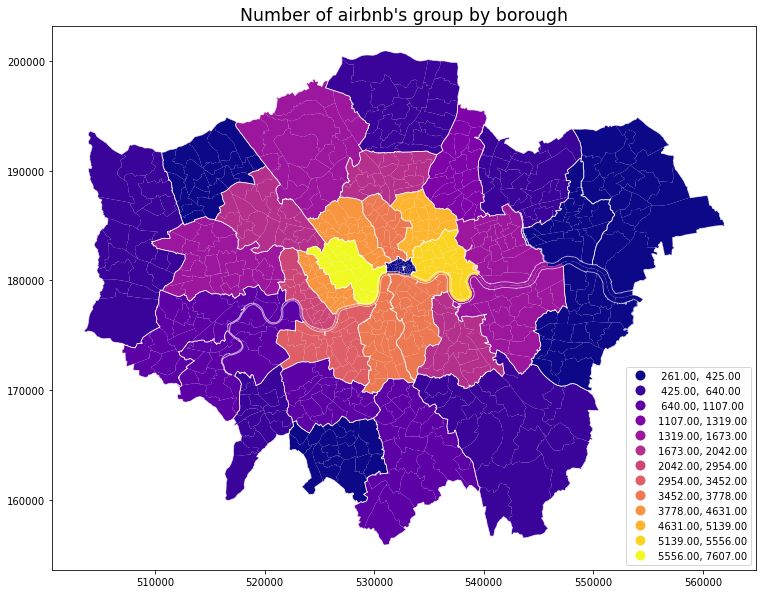

In [26]:
# Image presentation
ax = allgdf.plot(column='boroairbnbmeancnt', cmap='plasma', 
scheme='FisherJenks', k=13, edgecolor='None',linewidth = 0, legend=True, figsize=(15,10),legend_kwds={'loc':'lower right'});
boros.plot(ax=ax, edgecolor='w', facecolor='none', linewidth=0.8, alpha=0.7)
plt.title("Number of airbnb's group by borough",fontsize='xx-large')

## 4.3 Median House Price in London's Boroughs

In [27]:
# Calculating the median house price
allgdf['boromedinsohouse'] = allgdf.groupby('BOROUGH')['Median_House_Price_2014'].transform('median')

Text(0.5, 1.0, 'Median_House_Price_2014 group by borough')

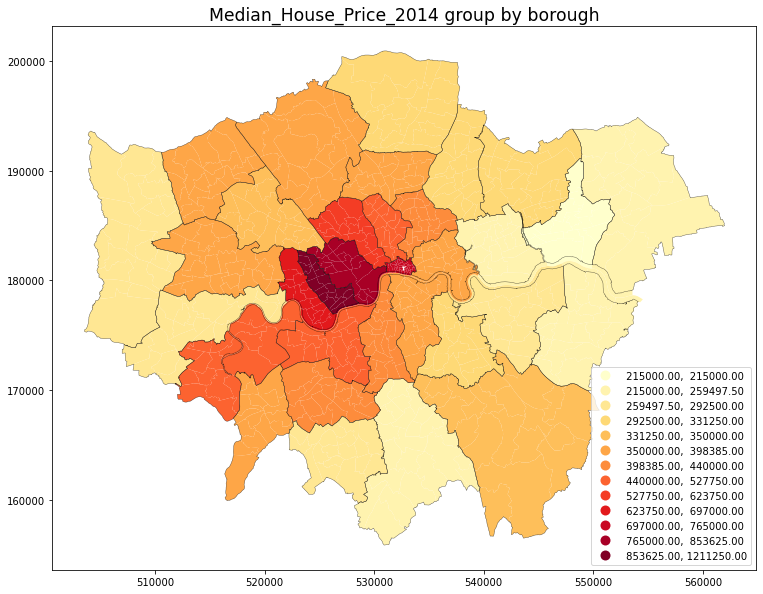

In [28]:
# Image presentation
ax = allgdf.plot(column='boromedinsohouse', cmap='YlOrRd', 
scheme='FisherJenks', k=13, edgecolor='None', linewidth = 0,legend=True, figsize=(15,10),legend_kwds={'loc':'lower right'});
boros.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.7)
plt.title("Median_House_Price_2014 group by borough",fontsize='xx-large')

## 4.4 Median House Price in London's Wards

Text(0.5, 1.0, 'Median_House_Price_2014 group by ward')

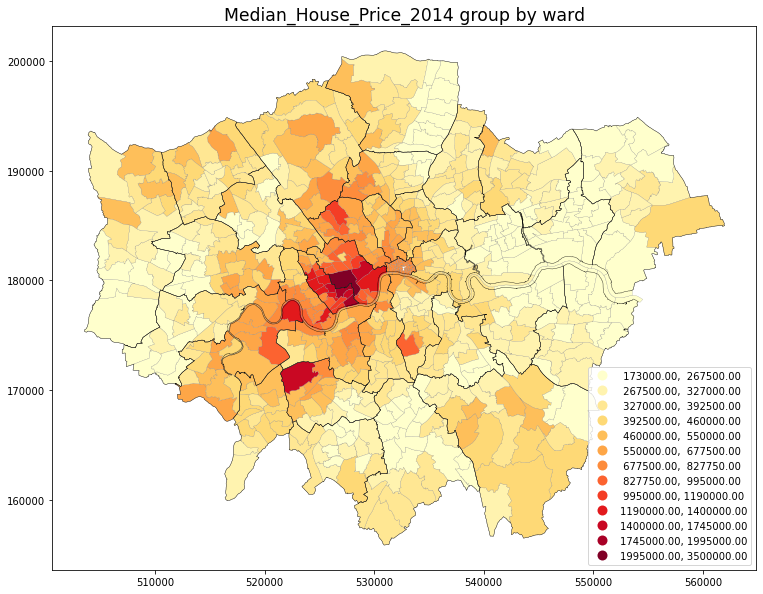

In [29]:
# Image presentation
ax = allgdf.plot(column='Median_House_Price_2014', cmap='YlOrRd', 
scheme='FisherJenks', k=13, edgecolor='gray', linewidth = 0.2,legend=True, figsize=(15,10),legend_kwds={'loc':'lower right'});
boros.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.9)

plt.title("Median_House_Price_2014 group by ward",fontsize='xx-large')

# 5. Multiple Linear Regression

## 5.1 Adjusting the Data to Normal Distributions

In [30]:
#Select the variables to be studied on the basis of the original data set
DY_MFU = allgdf.loc[:,['Median_House_Price_2014', 'airbnbcnt', 'price','Median_Household_income_estimate_2012_13','Population_density_2013']]
#Remove duplicate data columns
DY_MFU.drop(DY_MFU.head(24).index,inplace=True) 
#Delete extreme value points
DY_MFU = DY_MFU[DY_MFU['Median_House_Price_2014'] <= 700000]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


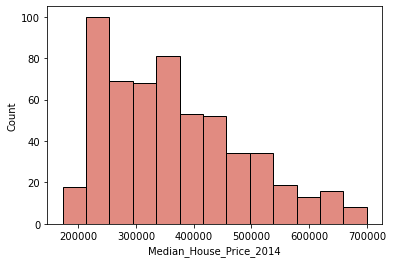

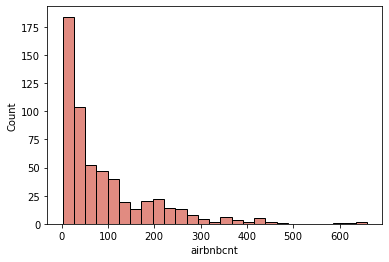

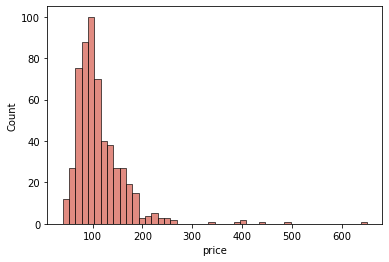

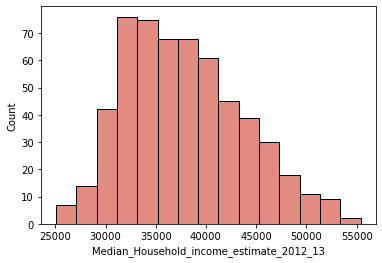

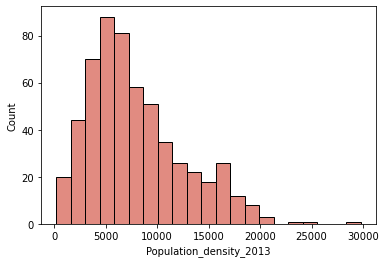

In [31]:
# Define the data frequency distribution graph generation function
def Box_Plt(file,a):
    df1 = file
    sns.histplot(df1[a],color = "#D86457")
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    plt.show() 
#Traversing the data and plotting the frequency distribution of each variable
for c in DY_MFU.columns.values:
    Box_Plt(DY_MFU,c)

#In terms of the distribution of the images, 'airbnbcnt','price' do not conform to a normal distribution
#need to be varied to make them conform to a normal distribution

-0.01250108767333824


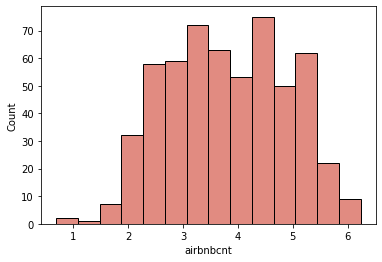

-0.48586252318872664


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


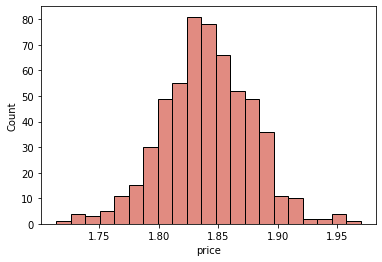

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [32]:
#Define the normal distribution transformation function
def Box_Change(file,a):
    df1 = file
    print(stats.boxcox_normmax(df1[a]))
    x = stats.boxcox(df1[a],stats.boxcox_normmax(df1[a]))
    sns.histplot(x,color = "#D86457")
    plt.show()
    df1[a] = stats.boxcox(df1[a],stats.boxcox_normmax(df1[a]))
#Perform normal distribution transformation
Box_Change(DY_MFU,"airbnbcnt")
Box_Change(DY_MFU,"price")

## 5.2 Scaling the Data

In [33]:
#Robustly Rescale
#Scaling by 10th decile and 9th decile
rs = RobustScaler(quantile_range=(10.0, 90.0))
for c in DY_MFU.columns.values:
   DY_MFU[c] = rs.fit_transform(DY_MFU[c].values.reshape(-1, 1))


## 5.3 Constructing Multiple Linear Regression Models

In [34]:
# Analysis of the effect of each variable on London house prices using ols regression
from statsmodels.formula.api import ols 
cnthum_ols = ols('Median_House_Price_2014 ~ airbnbcnt + Median_Household_income_estimate_2012_13 + Population_density_2013', data=DY_MFU).fit()
cnthum_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Median_House_Price_2014   R-squared:                       0.675
Model:                                 OLS   Adj. R-squared:                  0.673
Method:                      Least Squares   F-statistic:                     388.5
Date:                     Wed, 18 Jan 2023   Prob (F-statistic):          1.75e-136
Time:                             01:22:07   Log-Likelihood:                 32.423
No. Observations:                      565   AIC:                            -56.85
Df Residuals:                          561   BIC:                            -39.50
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0112      0.010      1.097      0.273      -0.009       0.031
airbnbcnt                                    0.3411      0.034     10.035      0.000       0.274       0.408
Median_Household_income_estimate_2012_13     0.7243      0.026     27.578      0.000       0.673       0.776
Population_density_2013                      0.2212      0.035      6.326      0.000       0.153       0.290
==============================================================================
Omnibus:                       35.675   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.491
Skew:                           0.556   Prob(JB):                     2.18e-10
Kurtosis:                       3.807   Cond. No.                         4.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5.4 VIF Analysis

In [35]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [36]:
#Excluding the dependent variable of house price and analysing the multicollinearity between the other variables in the fitted model
HDI_MFU_VIF = drop_column_using_vif_(DY_MFU.drop('Median_House_Price_2014', axis=1))
#From the VIF results, there is no multicollinearity between the independent variables

## 5.5 Residual Analysis

Text(0.5, 1.0, 'Residual vs. Fitted house_price_of_unit_area')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


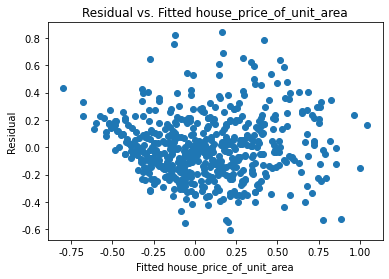

In [37]:
#Plot the residuals and test the model
plt.scatter(cnthum_ols.fittedvalues,cnthum_ols.resid)
# adding title and labels
plt.xlabel('Fitted house_price_of_unit_area')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted house_price_of_unit_area')
#plt.sh

# 6. Other

## 6.1 Github link for submitting a copy
https://github.com/TiannanGe/CASA/blob/28e1b5a3946bc8b5a8e45c5f4f86aadb56575178/CASA13Foundation/CASA0013%20European%20R&D%20Centre.ipynb